In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/MVA_RP/

/content/drive/MyDrive/MVA_RP


In [3]:
%ls

additional_files_dreem/  X_test_PN3J7aD.csv   y_train_tX9Br0C.csv
metric_dreem.py          X_train_h7ipJUo.csv
RP.ipynb                 y_benchmark.csv


In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import torch
import pandas as pd

plt.rcParams["figure.figsize"] = (15, 15)

[505.   2.]


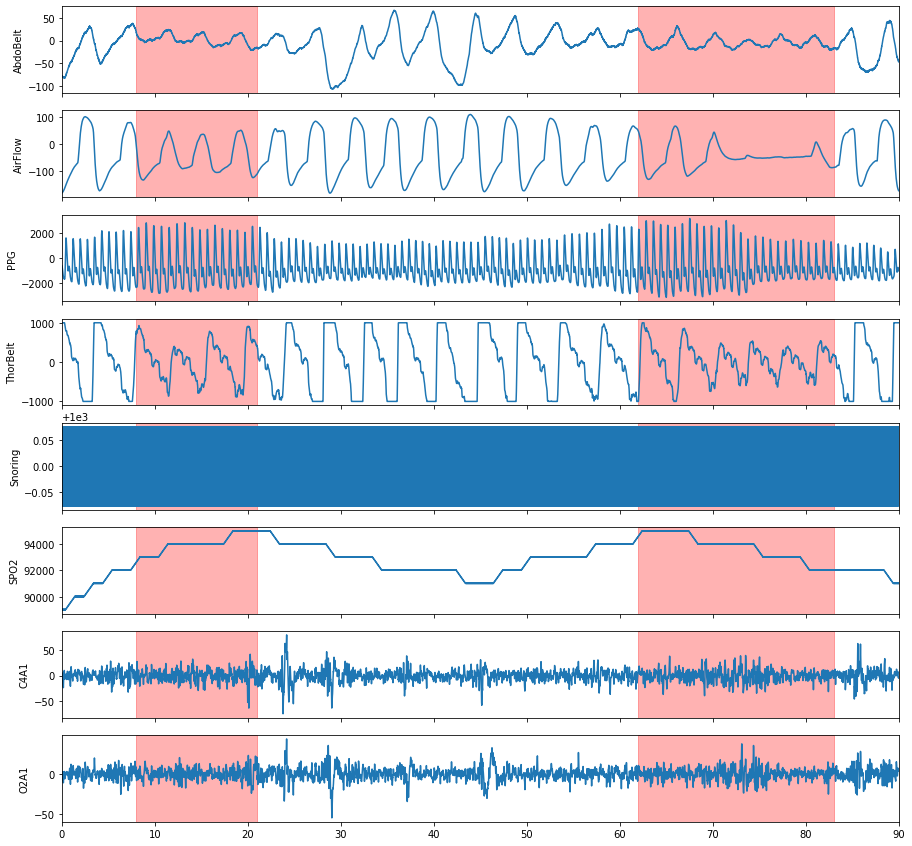

In [25]:
SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]


def extract_events_from_binary_mask(binary_mask, fs=1):
    binary_mask = np.array([0] + binary_mask.tolist() + [0])
    diff_data = np.diff(binary_mask)
    starts = np.where(diff_data == 1)[0] / fs
    ends = np.where(diff_data == -1)[0] / fs

    assert len(starts) == len(ends)
    events = []
    for i, _ in enumerate(starts):
        events += [(starts[i], ends[i])]

    return events


def visualize_signal_and_event(X, mask, signals_name=SIGNALS_NAME, signal_freq=100):
    n_signal = X.shape[0]
    fig, axs = plt.subplots(n_signal, sharex=True)
    events = extract_events_from_binary_mask(mask)
    for i in range(n_signal):
        axs[i].plot(np.arange(0, X[i].shape[0]) / signal_freq, X[i])
        axs[i].set_ylabel(signals_name[i])
        for elt in events:
            axs[i].axvspan(elt[0], elt[1], color='red', alpha=0.3)
    plt.xlim(0, X[0].shape[0]/ signal_freq)
    plt.show()


def visualise_index(idx, data_h5, masks, N_signals=8,data = None):
    print(data_h5['data'][idx, :2])
    x = data_h5['data'][idx, 2:]
    x = x.reshape(N_signals, -1)
    if not (data is None):
        x = data[idx]
    visualize_signal_and_event(x, np.array(masks[idx, 1:]))

plt.rcParams["figure.figsize"] = (15, 15)

PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train.h5"
PATH_TO_TRAINING_TARGET = "y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
idx_anomaly = np.where(np.sum(mask[:,1:],axis=1) > 1)[0]
idx_anomaly[0]

visualise_index(idx_anomaly[56], h5_file, mask)

In [27]:
data = h5_file['data']

In [28]:
def normalize_dataset_per_patient(data):
    num_patient = data[:, 1]

    data = data[:, 2:]
    data = data.reshape((data.shape[0], 8, 9000))
    norm_data = np.zeros(data.shape)
    
    patients = np.unique(num_patient)

    for p in patients:
        patient_data = data[num_patient==p]
        mean0 = np.mean(patient_data, axis = 2)
        std0  = np.std(patient_data, axis = 2)
        patient_data = (patient_data - mean0[:,:,np.newaxis])/std0[:,:,np.newaxis]
        norm_data[num_patient==p] = patient_data
    return norm_data

norm_data = normalize_dataset_per_patient(data)

[18.  0.]


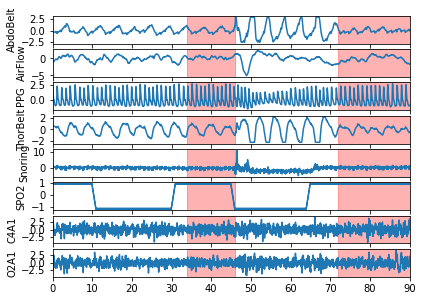

[18.  0.]


In [41]:
visualise_index(idx_anomaly[1], h5_file, mask,data = norm_data)
visualise_index(idx_anomaly[1], h5_file, mask,)

[488.   2.]


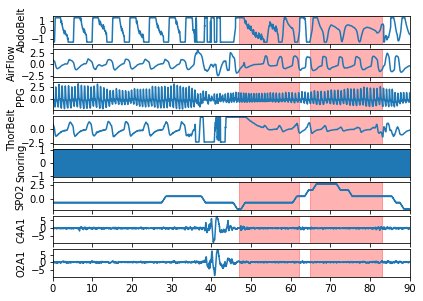

[488.   2.]


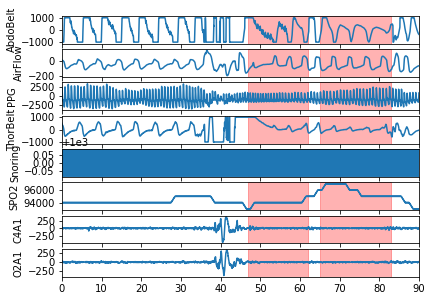

In [42]:
visualise_index(idx_anomaly[50], h5_file, mask,data = norm_data)
visualise_index(idx_anomaly[50], h5_file, mask,)

[652.   3.]


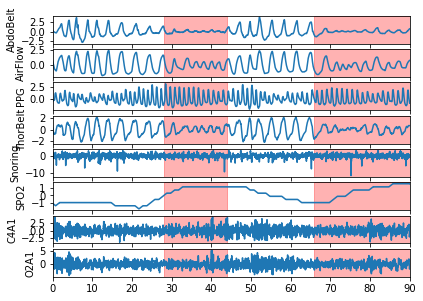

In [40]:
visualise_index(idx_anomaly[100], h5_file, mask,data = norm_data)

In [13]:
np.unique([1,1,1,2,2,3,3],return_index=False)

array([1, 2, 3])

## Exemple de transformé en ondelettes

(72000,)
[16.84597632 16.48083372 14.8936656  ... -7.13048995 -5.66130066
 -2.96891621]


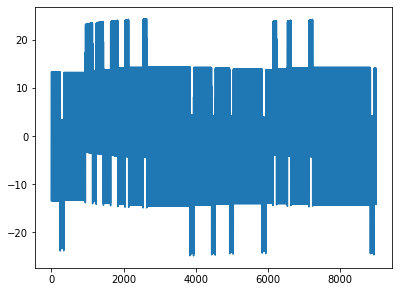

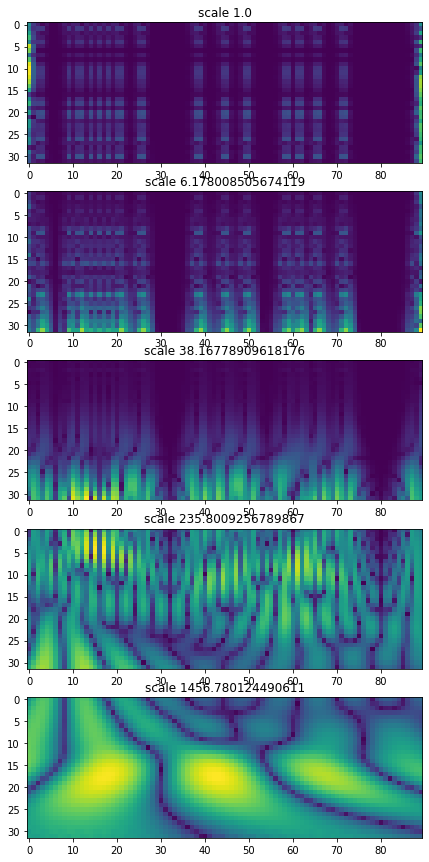

In [37]:
import pywt
from PIL import Image

SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]

plt.rcParams["figure.figsize"] = (6.4, 4.8)

N_signals = len(SIGNALS_NAME)
signal_freq = 100

x = h5_file['data'][idx_anomaly[44]][2:]
print(x.shape)
n_sig = 5
print(x)
x = x.reshape(N_signals, -1)[n_sig,:]
cut  = 1
# x = x[(cut*len(x)//2):((cut+1)*len(x)//2)]
x = np.concatenate((x[1:] - x[:-1],[0]))

n_cut = 5
plt.plot(x)
plt.show()
f, axs = plt.subplots(n_cut,1,figsize=(15,15))
# axs[0].plot(np.arange(0, x.shape[0]) / signal_freq, x)
for i in range(n_cut):
    
    coef, freqs=pywt.cwt(x,np.logspace(np.log10(x.shape[0])*i/n_cut,np.log10(x.shape[0])*(i+1)/n_cut,32),'morl')

    img = Image.fromarray(coef)
    img = img.resize((90,coef.shape[0]))
    img.size
    resized_coef = np.array(img)
    axs[i].set_title(f'scale {np.logspace(np.log10(x.shape[0])*i/n_cut,np.log10(x.shape[0])*(i+1)/n_cut,32)[0]}')
    axs[i].imshow(np.sqrt(np.abs(resized_coef)))



## avec une sinus

In [ ]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(np.abs(coef)) # doctest: +SKIP
plt.show() # doctest: +SKIP

In [55]:
import time

scales = np.logspace(0,np.log10(500),8)
print(scales)
N_sample, T_size = h5_file['data'].shape
# N_sample = 10

n_signal = len(SIGNALS_NAME)
T_size = T_size//n_signal

Data = np.zeros((N_sample, n_signal, len(scales), T_size))
start=time.time()
for idx in range(N_sample):
    print(idx, time.time()-start)
    X = h5_file['data'][idx, 2:]
    X = x.reshape(N_signals, -1)
    for i in range(n_signal):
        coef, freqs = pywt.cwt(X[i],scales,'morl')
        coef = np.sqrt(np.abs(coef))*np.sign(coef)
        Data[idx,i,:,:] = coef

try:
    hf_wt.close()
except:
    pass

hf_wt = h5py.File('WT_train.h5', 'w')
hf_wt.create_dataset('dataset_1', data=Data)
       


[  1.           2.42978107   5.90383603  14.345029    34.85527984
  84.690699   205.77985689 500.        ]
0 0.00015425682067871094
1 0.2574491500854492
2 0.5416271686553955
3 0.8086612224578857
4 1.0723862648010254
5 1.329632043838501
6 1.6024813652038574
7 1.860781192779541
8 2.110145092010498
9 2.3581182956695557
10 2.6228981018066406
11 2.8827521800994873
12 3.1312592029571533
13 3.3793952465057373
14 3.6303632259368896
15 3.8971750736236572
16 4.144934177398682
17 4.404179096221924
18 4.662774085998535
19 4.942121982574463
20 5.200055122375488
21 5.459273099899292
22 5.7512431144714355
23 6.080918073654175
24 6.343491077423096
25 6.592817306518555
26 6.852772235870361
27 7.136916160583496
28 7.389655113220215
29 7.635728359222412
30 7.884235143661499
31 8.145549058914185
32 8.402157068252563
33 8.65368914604187
34 8.916434049606323
35 9.192278146743774
36 9.444303274154663
37 9.70127534866333
38 9.96195912361145
39 10.218974113464355
40 10.477385997772217
41 10.728216171264648
42 

KeyboardInterrupt: 

In [56]:
N_sample

4400

## plot des scalegrammes pour chaque signaux

[461.   2.]
[  1.           3.12090331   9.74003746  30.39771515  94.86832981
 296.07488441 924.02108647]


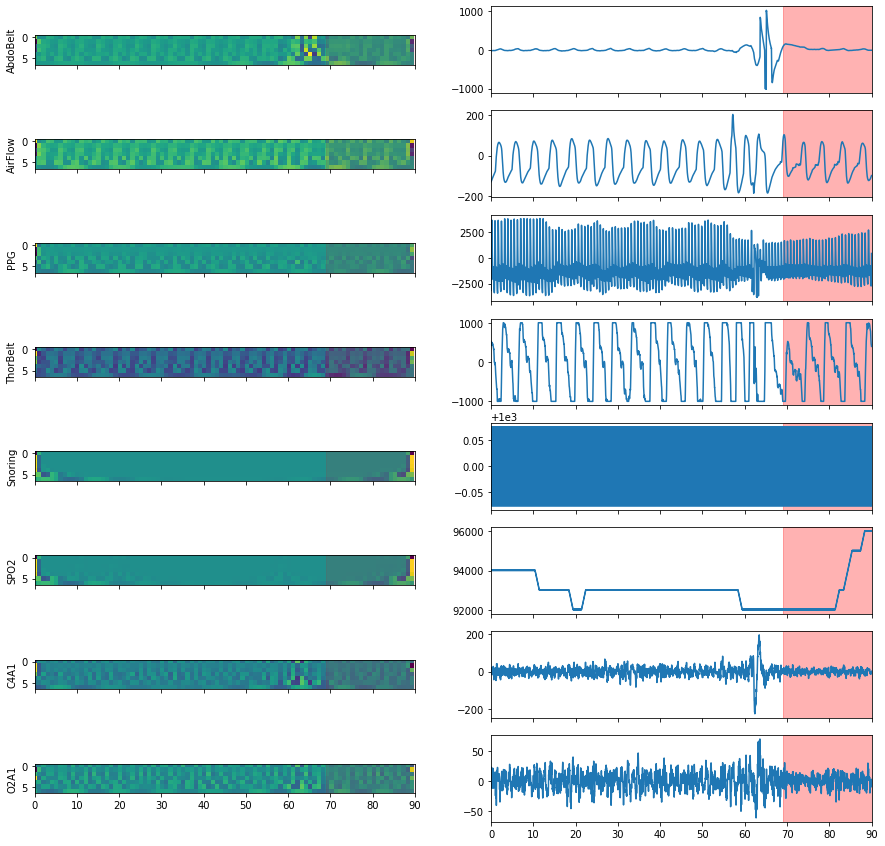

In [51]:


def visualize_signal_and_event_w(X, mask, signals_name=SIGNALS_NAME, signal_freq=100):
    n_signal = X.shape[0]
    fig, axs = plt.subplots(n_signal,2, sharex=True)
    events = extract_events_from_binary_mask(mask)
    for i in range(n_signal):
        x = X[i]
        scales = np.logspace(0,np.log10(x.shape[0])*3/4,7) 
        coef, freqs=pywt.cwt(x,scales,'morl')
        img = Image.fromarray(coef)
        img = img.resize((90,coef.shape[0]))
        img = np.array(img)
        resized_coef = np.sqrt(np.abs(img))*np.sign(img)
        resized_coef = resized_coef/np.std(resized_coef,axis=1)[:,np.newaxis]
        axs[i,0].imshow(resized_coef)
        axs[i,0].set_ylabel(signals_name[i])
        axs[i,1].plot(np.arange(0, x.shape[0]) / signal_freq, x)


        for elt in events:
            axs[i,0].axvspan(elt[0], elt[1], color='red', alpha=0.1)
            axs[i,1].axvspan(elt[0], elt[1], color='red', alpha=0.3)

    print(scales)
    plt.xlim(0, X[0].shape[0]/ signal_freq)
    plt.show()


def visualise_index_w(idx, data_h5, masks, N_signals=8):
    print(data_h5['data'][idx, :2])
    x = data_h5['data'][idx, 2:]
    x = x.reshape(N_signals, -1)

    visualize_signal_and_event_w(x, np.array(masks[idx, 1:]))
    
plt.rcParams["figure.figsize"] = (15, 15)

PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train.h5"
PATH_TO_TRAINING_TARGET = "y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
idx_anomaly = np.where(np.sum(mask[:,1:],axis=1) > 1)[0]
idx_anomaly[0]

visualise_index_w(idx_anomaly[42], h5_file, mask)
# visualise_index(idx_anomaly[41], h5_file, mask)


## Wavelet vs. signal plot

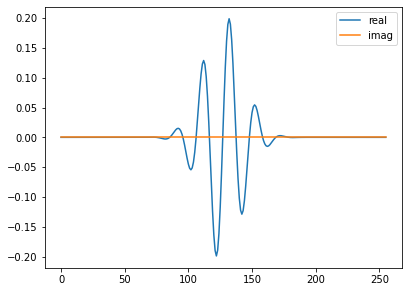

[1.00000000e+00 8.19036259e+00 6.70820393e+01 5.49426225e+02
 4.50000000e+03]


In [16]:

wav_type = 'shan50-50'
wav_type = 'morl'
wav = pywt.ContinuousWavelet(wav_type)

int_psi, x = pywt.integrate_wavelet(wav)
int_psi = np.asarray(int_psi)
plt.figure()
plt.plot(int_psi.real, label = 'real')
plt.plot(int_psi.imag, label = 'imag')
plt.legend()
plt.show()

data = h5_file['data'][idx_anomaly[44]][2:]
n_sig = 7
data = data.reshape(N_signals, -1)[n_sig,:]

data = data - np.mean(data)
data = np.max(np.abs(int_psi))*data/np.max(data)
data = data[len(data)//4:len(data)*3//4]

scales = np.logspace(0,np.log10(data.shape[0]),5)
coef, freqs = pywt.cwt(data,scales,wav_type)
coef = np.abs(coef)
print(scales)

fig, axes = plt.subplots(len(scales),2, figsize=(15,15))

for i, scale in enumerate(scales):
    step = x[1] - x[0]
    j = np.arange(scale * (x[-1] - x[0]) + 1) / (scale * step)
    j = j.astype(int)  # floor
    if j[-1] >= int_psi.size:
        j = np.extract(j < int_psi.size, j)
    int_psi_scale = int_psi[j][::-1]
    axes[i,0].plot(int_psi_scale.real)
    axes[i,0].plot(int_psi_scale.imag)

    axes[i,0].plot(data)
    
    axes[i,1].plot(coef[i,:])
    
    axes[i,0].set_title(f'scale : {scale}')


### conclusion

Les scales trop grandes ne servent à rien, en plus il y a beaucoup d'artefact.

Les scales en dessous de la freq d'échantillonage ne servent à rien non plus.

## Creating H5D file for WT

In [56]:

PATH_TO_TRAINING_DATA = "WT_train.h5"
PATH_TO_TRAINING_TARGET = "y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)


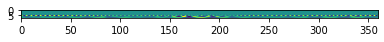

In [61]:
plt.imshow(h5_file['data'][0,2])

# Soft masks


In [62]:
idx_anomaly = np.where(np.sum(masks,axis=1) > 1)[0]
soft_mask = np.zeros(masks.shape)
D = 5
N = masks.shape[1]

for k in idx_anomaly:
  target = masks[k]
  interval_target = []
  N = len(target)
  new_target = np.zeros(N)
  nb_ones = np.zeros(N)
  for i in range(N):
    x = np.zeros(N)
    x[max(0,i-D):min(N,i+D+1)] = 1
    nb_ones[i] = np.sum(x)
    new_target[i] = np.sum(target*x/nb_ones[i])
  new_target = new_target/np.max(new_target)
  soft_mask[k] = new_target

plt.figure(figsize=(6,6))
plt.plot(soft_mask[idx_anomaly[100]],color = 'blue')
plt.plot(masks[idx_anomaly[100]],color = 'red')


NameError: name 'masks' is not defined

# Jaccard stuff


In [ ]:
def jaccard_overlap(localizations_a, localizations_b):
    """Jaccard overlap between two segments A ∩ B / (LENGTH_A + LENGTH_B - A ∩ B)

    localizations_a: list of localizations
    localizations_a: list of localizations

    return:
        (ndarray)
    """
    size_set_A = len(localizations_a)
    size_set_B = len(localizations_b)

    localizations_a_start = [localization[0] for localization in localizations_a]
    localizations_a_end = [localization[1] for localization in localizations_a]

    localizations_b_start = [localization[0] for localization in localizations_b]
    localizations_b_end = [localization[1] for localization in localizations_b]

    localizations_a_start = np.array([localizations_a_start for _ in range(size_set_B)])
    localizations_a_end = np.array([localizations_a_end for _ in range(size_set_B)])

    localizations_b_start = np.transpose(np.array([localizations_b_start for _ in range(size_set_A)]))
    localizations_b_end = np.transpose(np.array([localizations_b_end for _ in range(size_set_A)]))

    length_a = localizations_a_end - localizations_a_start
    length_b = localizations_b_end - localizations_b_start


    # intersection
    max_min = np.maximum(localizations_a_start, localizations_b_start)
    min_max = np.minimum(localizations_a_end, localizations_b_end)
    intersection = np.maximum((min_max - max_min), 0)

    try:
        overlaps = intersection / (length_a + length_b - intersection)
    except:
        print('here')
    return overlaps


def extract_events_from_binary_mask(binary_mask, fs=1):
    binary_mask = np.array([0] + binary_mask.tolist() + [0])
    diff_data = np.diff(binary_mask)
    starts = np.where(diff_data == 1)[0] / fs
    ends = np.where(diff_data == -1)[0] / fs

    assert len(starts) == len(ends)
    events = []
    for i, _ in enumerate(starts):
        events += [(starts[i], ends[i])]

    return events


def compute_f1_score(event_pred, event_true):
    total_tp = 0
    total_fp = 0
    total_fn = 0
    for idx in range(event_pred.shape[0]):
        tp, fp, fn = compute_tp_fp_fn_for_each_entry(event_pred[idx], event_true[idx])
        total_tp += tp
        total_fp += fp
        total_fn +=fn

    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    if precision == 0 or recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)

    return f1_score


def compute_tp_fp_fn_for_each_entry(prediction, reference, min_iou=0.3):
    """takes 2 event scorings
        (in array format [[start1, end1], [start2, end2], ...])
        and outputs the f1 score.

        Parameters
        ----------
        min_iou : float
            minimum intersection-over-union with a true event to be considered
            a true positive.
        """
    if len(prediction) == 0:
        return 0, 0, len(reference)
    if len(reference) == 0:
       return 0, len(prediction), 0

    iou = jaccard_overlap(prediction, reference)

    # Number of true events which are matched by a predicted events
    TP1 = np.sum(np.amax((iou >= min_iou), axis=0))
    # Number of predicted events which match a true event
    TP2 = np.sum(np.amax((iou >= min_iou), axis=1))

    # In order to avoid duplicate, a true event can only match a true events and a predicted event
    true_positive = min(TP1, TP2)
    false_positive = len(prediction) - true_positive
    false_negative = len(reference) - true_positive

    return true_positive, false_positive, false_negative


def format_predictions_for_scoring(mask, window_length=100):
    """
    Stack events in one single list for F1 computation
    :param mask:
    :param window_length:
    :return:
    """
    result = []
    for i, elt in enumerate(mask):
        events = extract_events_from_binary_mask(elt)
        if len(events) > 0:
            events = [[i * window_length + start, i * window_length + end] for start, end in events]
        else:
            events = []
        result.append(events)
    return np.array(result)


def dreem_sleep_apnea_custom_metric(y_pred, y_true):
    event_true = format_predictions_for_scoring(np.array(y_pred))
    event_pred = format_predictions_for_scoring(np.array(y_true))
    return compute_f1_score(event_pred, event_true)


if __name__ == '__main__':
    CSV_FILE_Y_TRUE = 'y_benchmark.csv'
    CSV_FILE_Y_PRED = 'y_benchmark.csv'
    df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
    df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
    print(dreem_sleep_apnea_custom_metric(df_y_true, df_y_pred))